# Бизнес процесс.
Задача - изучить бизнес процесс, который работает в соответствии со схемой:
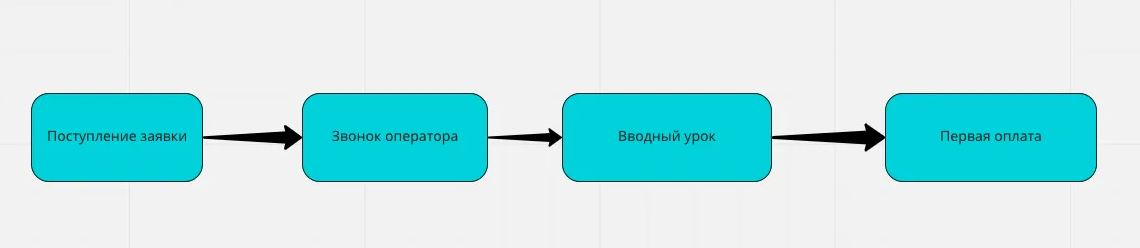

Сформулировать гипотезы о влиянии разных факторов на конверсию, дать рекомендации

Импорт библиотек, чтение файлов

In [ ]:
!pip install pingouin

In [ ]:
import pandas as pd
import os
from datetime import timedelta
import scipy.stats as ss
import pingouin as pg
import statsmodels.stats.multicomp as ssm

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/applic_str_diff

/content/drive/MyDrive/Colab Notebooks/applic_str_diff


In [ ]:
df = pd.read_csv('applicant_task.csv', encoding='utf-8')
display(df.head(4))

,order_id,source,application_datetime,gender,first_call,first_reach,operator_group_type,operator_group_name,trial_appointment_datetime,appointment_added_by_id,is_paid
0,10457322,a636bcf354a837fb5c25c3d5b940170b,2020-04-03 04:10:45,1.0,2020-04-03 16:43:59.508792,2020-04-03 22:11:27.455366,a170e8b5b0085420fa52f9f9e1d546f9,d4f622b69e50e86a65cd6fae4bcf575f,2020-04-04 15:28:14.798018,6620229,0
1,11236929,91ce888e6774bd668a675b5640499103,2020-07-12 03:31:39,NaN,2020-07-12 04:47:12.312267,2020-07-12 07:05:38.094529,a170e8b5b0085420fa52f9f9e1d546f9,d4f622b69e50e86a65cd6fae4bcf575f,2020-07-12 15:02:07.545403,4578767,0
2,10246280,91ce888e6774bd668a675b5640499103,2020-02-01 03:19:28,NaN,2020-02-04 04:45:20.910754,2020-02-04 10:42:35.204203,e908f62885515872936a2bf07e5960a0,a0b8ef7535f9201f77c5a97d2ba4db2b,2020-02-02 07:07:41.388133,6290758,0
3,11058994,a636bcf354a837fb5c25c3d5b940170b,2020-05-19 06:18:16,0.0,2020-05-19 07:18:45.609637,2020-05-19 08:39:54.048419,a170e8b5b0085420fa52f9f9e1d546f9,d4f622b69e50e86a65cd6fae4bcf575f,2020-05-19 13:01:02.901309,4700850,0


## Предварительный EDA
Приведение типов колонок.

In [ ]:
df['application_datetime'] = pd.to_datetime(df['application_datetime'], format="%Y-%m-%d %H:%M:%S")
df[['trial_appointment_datetime','first_call', 'first_reach']]  \
  = df[['trial_appointment_datetime','first_call', 'first_reach']] \
  .apply(pd.to_datetime, format="%Y-%m-%d %H:%M:%S.%f")

In [ ]:
print(df.shape)
df.dtypes

(10000, 11)


,0
order_id,int64
source,object
application_datetime,datetime64[ns]
gender,float64
first_call,datetime64[ns]
first_reach,datetime64[ns]
operator_group_type,object
operator_group_name,object
trial_appointment_datetime,datetime64[ns]
appointment_added_by_id,int64


Проверка на дубли

In [ ]:
print(df.order_id.count())
print(df.order_id.nunique())

10000
10000


In [ ]:
print(df.trial_appointment_datetime.count())


10000


In [ ]:
print('Коверсия заявки в пробный урок', end=': ')
print(df.trial_appointment_datetime.count()/df.order_id.nunique())
print('Коверсия пробного урока в оплату', end=': ')
print(df[df['is_paid']==1].is_paid.count()/df.trial_appointment_datetime.count())

Коверсия заявки в пробный урок: 1.0
Коверсия пробного урока в оплату: 0.5018


In [ ]:
display(df.nunique())
df[['operator_group_type','operator_group_name']].groupby('operator_group_type').nunique()

,0
order_id,10000
source,29
application_datetime,9996
gender,2
first_call,10000
first_reach,9418
operator_group_type,3
operator_group_name,24
trial_appointment_datetime,10000
appointment_added_by_id,1101


,operator_group_name
operator_group_type,
21790c97eeb6336e5f0fdb9ef4de636f,19
a170e8b5b0085420fa52f9f9e1d546f9,4
e908f62885515872936a2bf07e5960a0,1


## Формулировка гипотез и их проверка
Гипотезы, что может влиять на конверсию:
1. Время, прошедшее от заявки до успешного звонка (клиент поднял трубку)
2. Время, прошедшее от звонка до пробного урока
3. Разные группы операторов могут иметь разный подход к клиентам, что влияет на конверсию.

Модель нашего бизнес процесса: Заявка->разговор оператора с клиентом->пробный урок->покупка.  Если оператор не дозвонился либо очередность действий нарушена, это не соответствует нашей модели и такие строки считаются багом системы.

In [ ]:
print(df[df['application_datetime']>df['first_reach']].shape[0])
print(df[df['first_reach']>df['trial_appointment_datetime']].shape[0])

9
2987


Есть строки, не удовлетворяющие критерию очередности. Их, а также нулевые строки в точке подачи заявки и звонка нужно отфильтровать

In [ ]:
df = df[(df['application_datetime']<df['first_reach']) & \
        (df['first_reach']<df['trial_appointment_datetime']) & \
        (~df['application_datetime'].isna()) & \
        (~df['first_reach'].isna()) & \
        (~df['trial_appointment_datetime'].isna())
        ]
df.shape[0]

6422

In [ ]:
df = df.copy()
df['time_diff_a-r'] = df['first_reach'] - df['application_datetime']

Разобьем на 2 сегмента генеральную выборку по медиане прошедешго времени. Сформулируем нулевую гипотезу так - время от завяки до звонка не влияет на конверсию. Проверим ее.

In [ ]:
df1 = df.copy()
median_a_r_time = df1['time_diff_a-r'].median()  # Медианное время зявка - дозвон
df1_slow = df1[['time_diff_a-r','is_paid']][df1['time_diff_a-r']>median_a_r_time]  # "Медленные" случаи
df1_fast = df1[['time_diff_a-r','is_paid']][df1['time_diff_a-r']<median_a_r_time]  # "Быстрые" случаи
print('slow:')
display(df1_slow.groupby('is_paid', as_index=False).count())  # Сгруппированные таблицы для анализа конверсии
print('fast:')
display(df1_fast.groupby('is_paid', as_index=False).count())

slow:


,is_paid,time_diff_a-r
0,0,1570
1,1,1641


fast:


,is_paid,time_diff_a-r
0,0,1570
1,1,1641


Проверим гипотезу методом Хи-квадрат

In [ ]:
print(ss.chisquare(f_obs=(1570,1641), f_exp=(1570,1641)))
print(f'Конверсия в случае звонка более чем через {median_a_r_time} равна', end=': ')
print(round(df1_slow.is_paid.mean(),4))
print(f'Конверсия в случае звонка менее чем через {median_a_r_time} равна', end=': ')
print(round(df1_fast.is_paid.mean(),4))


Power_divergenceResult(statistic=0.0, pvalue=1.0)
Конверсия в случае звонка более чем через 0 days 09:31:04.725830 равна: 0.5111
Конверсия в случае звонка менее чем через 0 days 09:31:04.725830 равна: 0.5111


Стат значимых различий нет, нет основания отвергнуть нулевую гипотезу

Тепрь проверим влияние величины промежутка времени от звонка до пробного урока. Метод тот же, что и для гипотезы выше.  

In [ ]:
df['time_diff_r-t'] = df['trial_appointment_datetime'] - df['first_reach']
df2 = df.copy()

df2 = df2[['time_diff_r-t','is_paid']]
median_r_t_time = df2['time_diff_r-t'].median()  # Медианное время дозвон - урок-пробник
df2_slow = df2[df2['time_diff_r-t']>median_r_t_time]  # "Медленные" случаи
df2_fast = df2[df2['time_diff_r-t']<median_r_t_time]  # "Быстрые" случаи
print('slow:')
display(df2_slow.groupby('is_paid', as_index=False).count())
print('fast:')
display(df2_fast.groupby('is_paid', as_index=False).count())

slow:


,is_paid,time_diff_r-t
0,0,1577
1,1,1634


fast:


,is_paid,time_diff_r-t
0,0,1563
1,1,1648


In [ ]:
print(ss.chisquare(f_obs=(1565,1650), f_exp=(1579,1636)))


Power_divergenceResult(statistic=0.243933596671472, pvalue=0.6213793880903944)


Стат значимых различий не обнаружено, оснований отвергнуть нулевую гипотезу нет.


Теперь исследуем влияние группы операторов на конверсию - как на генеральную совокупность, так и на разные гендеры. Возможно, что подходы операторов работают по-разному на мужчин и женщин.
Нулевая гипотеза - среднее количества оплат на клиента (конверсия) не зависит от типа групп операторов.

In [ ]:
df3 = df.copy()
df3 = df3[['gender','operator_group_type','is_paid']]
df3_lst=[]
for i in range(3):
  df3_lst.append(df3[df3['operator_group_type']==df3.operator_group_type.unique()[i]])

In [ ]:
bartlett_stat = ss.bartlett(df3_lst[0]['is_paid'], df3_lst[1]['is_paid'], df3_lst[1]['is_paid'])
# print(f'Тест Бартлетта: Статистика = {bartlett_stat}, p-значение = {bartlett_p}')
print(bartlett_stat)

BartlettResult(statistic=0.0010468492479202987, pvalue=0.9994767123388107)


По критерию Бартлетта дисперсии гомогенны. Проверим выборки при помощи дисперсионного анализа.

In [ ]:
ss.f_oneway(df3_lst[0]['is_paid'], df3_lst[1]['is_paid'], df3_lst[1]['is_paid'])

F_onewayResult(statistic=0.1135100705727428, pvalue=0.8926967381415715)

Стат значимых различий не обнаружено, оснований отвергнуть нулевую гипотезу нет.

Тем не менее, можно посмотреть влияние гендера и типа групп операторов методом ANOVA

In [ ]:
pg.anova(data=df3,dv='is_paid', between=['operator_group_type', 'gender'])

,Source,SS,DF,MS,F,p-unc,np2
0,operator_group_type,0.040306,2.0,0.020153,0.080510,0.922647,0.000049
1,gender,0.001846,1.0,0.001846,0.007376,0.931564,0.000002
2,operator_group_type * gender,0.033848,2.0,0.016924,0.067610,0.934626,0.000041
3,Residual,829.293851,3313.0,0.250315,NaN,NaN,NaN


Опять стат значимых различий нет. Наконец, проверим, что все группы операторов работают хорошо. Убедиться можно при помощи критерия Тюки:

In [ ]:
MultiComp = ssm.MultiComparison(df.is_paid, df.operator_group_name)

print(MultiComp.tukeyhsd().summary())

                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
             group1                           group2              meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------------------
3b574fbbeb9251641816c6c5e8140e62 41fcb0f55a2687355fff238d3bdf319e    0.037    1.0 -0.7108 0.7849  False
3b574fbbeb9251641816c6c5e8140e62 43c831a1511b89eeeb1c9086c4e90f35  -0.6296  0.991 -2.3169 1.0577  False
3b574fbbeb9251641816c6c5e8140e62 50b18bd0f19a885de1c8de8c46261398   0.3704    1.0 -1.3169 2.0577  False
3b574fbbeb9251641816c6c5e8140e62 63af698d7d79dadbc44ac71a068acea0  -0.6296 0.8875 -1.8439 0.5846  False
3b574fbbeb9251641816c6c5e8140e62 7048270b6e5da5858703cd2ef2998649   0.3704    1.0 -1.3169 2.0577  False
3b574fbbeb9251641816c6c5e8140e62 73231aa8aa7a12c078c764b0fd686b34  -0.6296  0.991 -2.3169 1.0577  False
3b574fbbeb9251641816c6c5e8140e62 a0b8ef7535f9201f77c5a97d2ba4db2

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


# ИТОГИ

1. Не обнаружено статистичиечки значимого влияния времени от заявки до разговора с оператором на конверсию.

2. Не обнаружено статистически значимой зависимости конверсии от промежутка времени между разговором клиента с оператором и пробным уроком.

3. Операторы в целом работают одинаково, нет возможности дать рекомендации.

PS. Статзначимые зависимости есть при невыполнении фильтрации данных (не показано в отчете). Тем не менее такой подход неверен - нет смысла говрить о влиянии оперативности звонка оператора, если пробный урок уже прошел.
Другие корреляции вообще нет смысла рассмтаривать - даже если есть стат значимые различия по гендеру или региону - нет смысла давать рекомендации по стигматизации одних групп в пользу других, это может навредить имиджу компании.

Для выявления возможных тактик повышения конверсии необходимо проводить дополнительные эксперименты, например менять дизайн сайта или рекламу и смотреть на А/Б тесты для них.